In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


This section loads the weather dataset prepared form *Deep Learning with Python*, where the example in the documentation comes from.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


Slice the dataframe into 10-minute intervals

In [3]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
df.shape

(70091, 14)

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


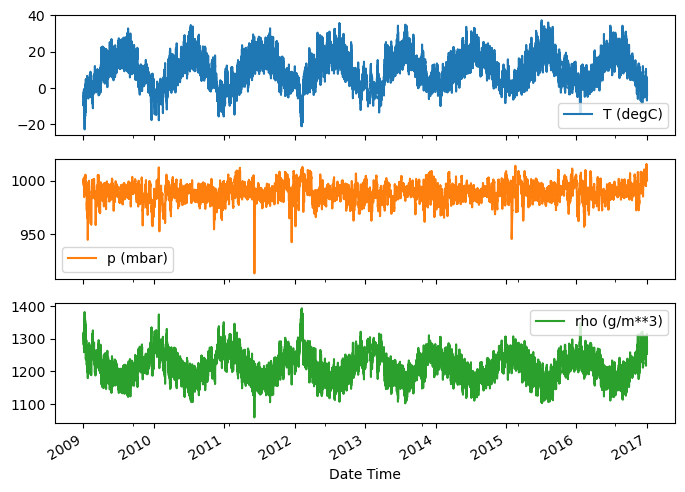

In [6]:
# Plot the chosen features over time
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

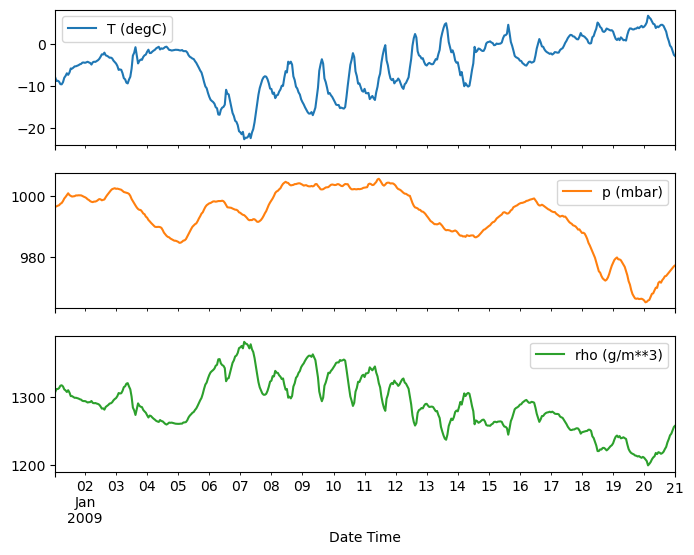

In [7]:
# Plot the same features but zoom in on a section
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [8]:
# Check out the stats of the dataset
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [9]:
# There are erroneous values in the wind vector column, where the minimum should be zero
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Feature Engineering

Angles don't make good predictors, so convert the wind speed and direction to velocity, a vector.

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

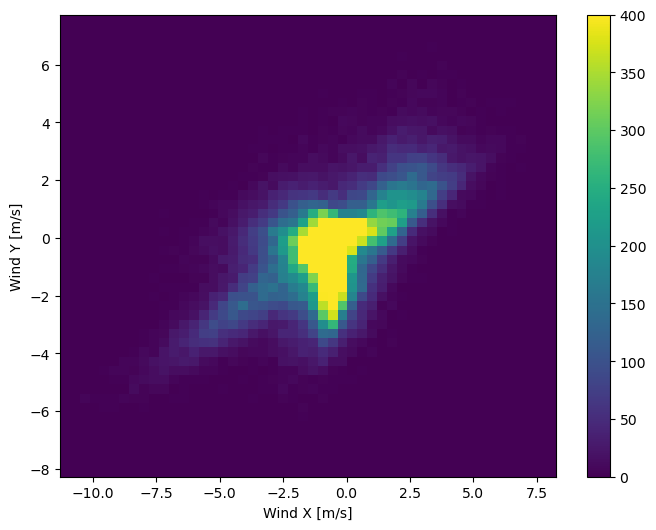

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [12]:
# Convert timestamp to seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

You can deal with periodicity, which are likely important factors, by sine and cosine transformations, if you know these features are important at the start.

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

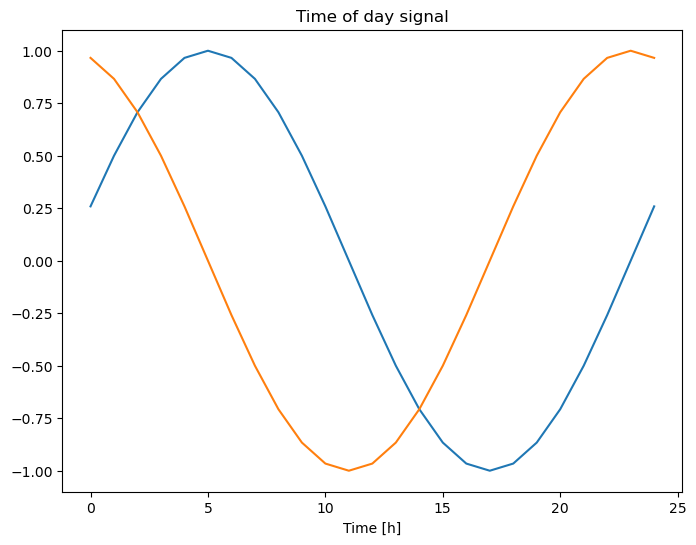

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')


If you don't know ahead of time which frequencies are important, you can determine that by Fast-Fourier Transforms.

2022-10-18 20:12:43.936965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


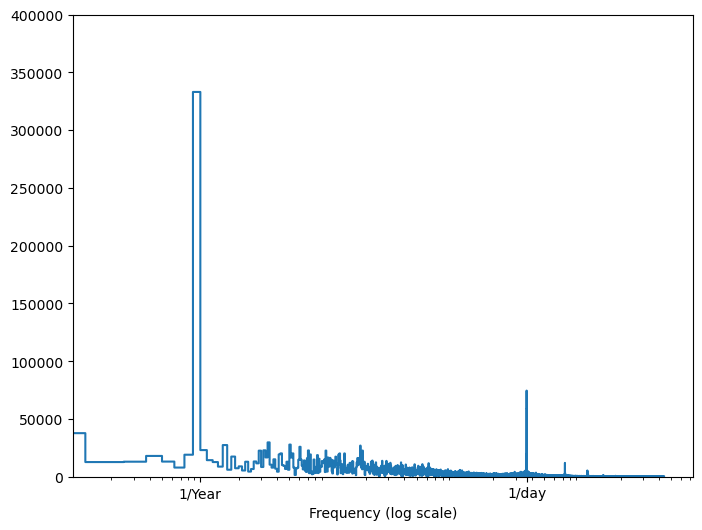

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

The data splits are not randomized to replicate real-life conditions, where predictions are received up to a point. It also ensures that chopping the time series into windows is still possible.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print("The training size is: ", train_df.shape)
print("The validation size is: ", val_df.shape)
print("The testing size is: ", test_df.shape)

The training size is:  (49063, 19)
The validation size is:  (14018, 19)
The testing size is:  (7010, 19)


It's important to scale or normalize the data before inputting into the neural network. Use the mean and standard deviation from the training dataset to scale all datasets.

Some argue that the model shouldn't have access to future values, and a rolling mean should be used.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

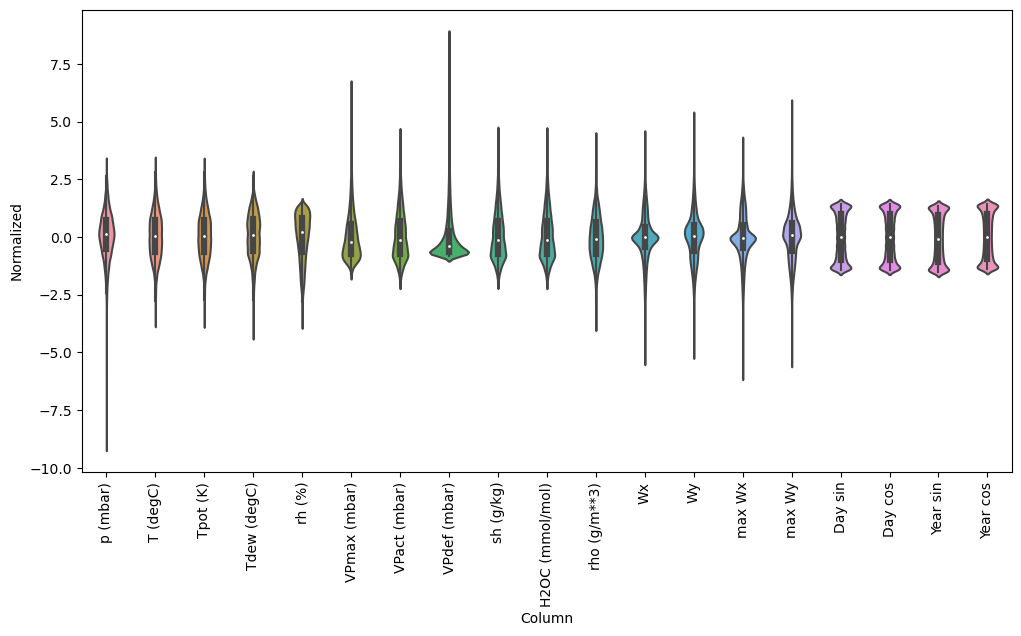

In [18]:
# Plot the distribution of the features, checking for any other errors
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### Data Windowing

The models make predictions based on continuous sequences as windows from the data. These are passed as `[batch, timestep, features]` into the RNN model. 

From the tutorial, "The main features of the input windows are:

    The width (number of time steps) of the input and label windows.
    The time offset between them.
    Which features are used as inputs, labels, or both.
"

In [21]:
### Create the WindowGenerator class
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices. Collect if specified in dataset?
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [22]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [23]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [25]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [26]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


"Initially, this tutorial will build models that predict single output labels."

In [28]:
w2.example = example_inputs, example_labels

In [29]:
# Create a plot method to view a split window
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Notice how the methods are added to the class one at a time. Could remember this if you ever need to add methods to someone else's class.

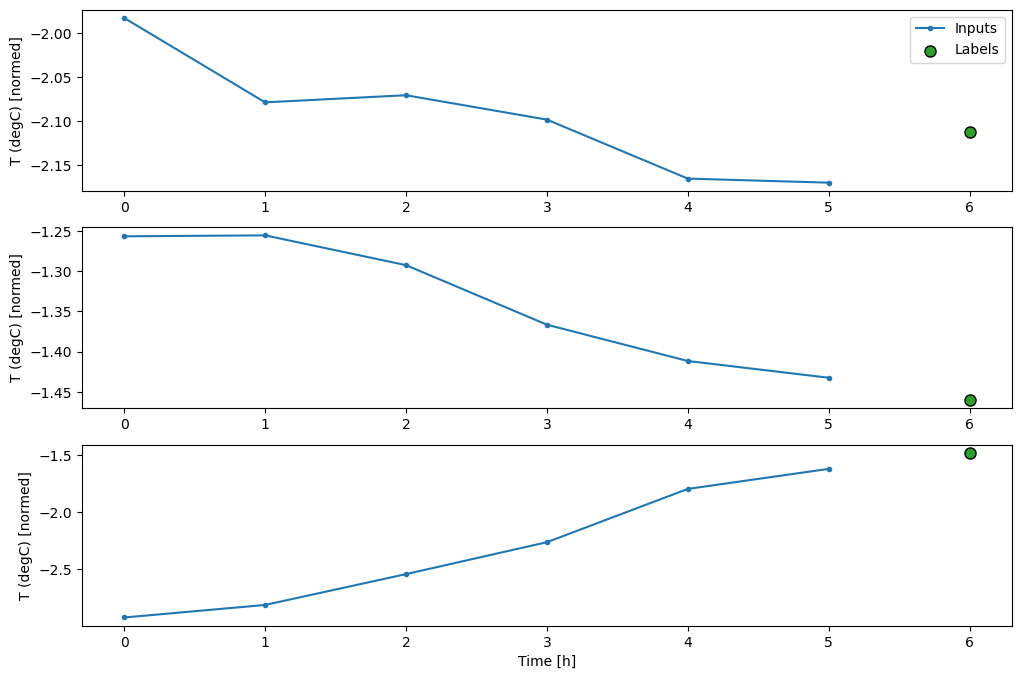

In [30]:
w2.plot()

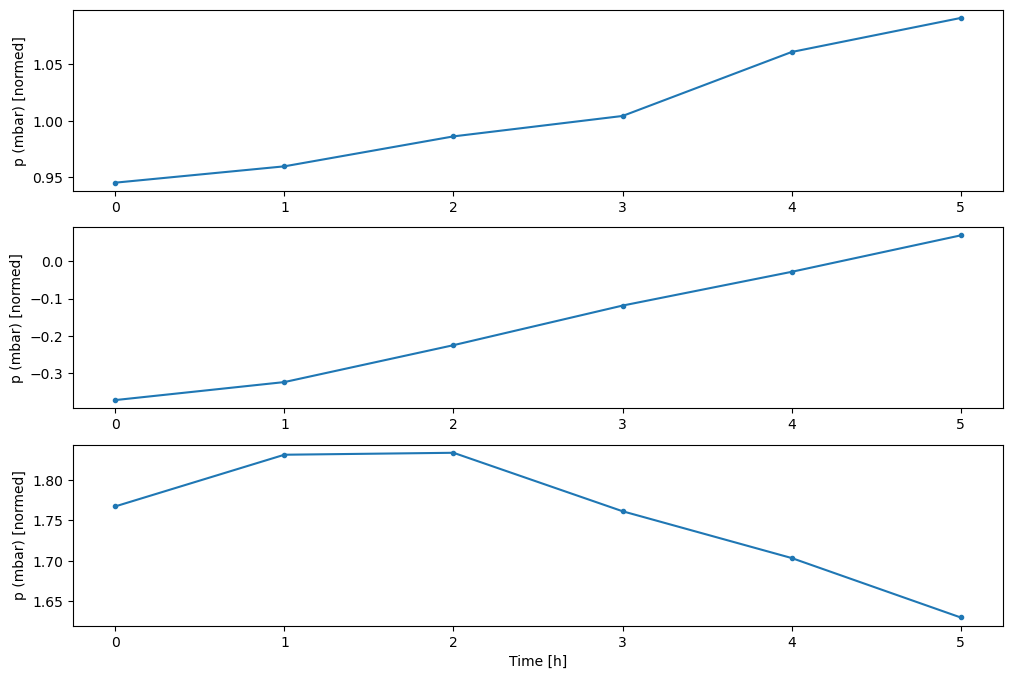

In [31]:
# Plot other columns like
w2.plot(plot_col='p (mbar)')


### Create Tensorflow Datasets

This method takes a Pandas DataFrame and converts it to a `tf.data.Dataset` of `(input_window, label_window)` pairs. 

In [69]:
def make_dataset(self, data):
    # Convert data to numpy array
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [70]:
### Add properties to access these are tf.data.Dataset objects using the just defined method
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [71]:
w2.train_df.head(10)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388
35,1.091135,-2.169649,-2.239029,-2.182875,1.014416,-1.354835,-1.579503,-0.786272,-1.581113,-1.583635,2.459016,0.274590,0.268633,0.175115,0.377528,1.414323,0.000102,-0.055937,1.428374
41,1.165857,-2.111879,-2.186305,-2.108294,1.026496,-1.340539,-1.550988,-0.784197,-1.554908,-1.557814,2.416777,1.308822,-0.008002,1.211039,0.057261,1.366133,-0.365907,-0.054914,1.428360
47,1.267093,-1.988250,-2.071689,-1.957698,1.020456,-1.305450,-1.493957,-0.780045,-1.495011,-1.499129,2.311058,-0.001703,-0.006445,-0.024096,0.004664,1.224850,-0.706974,-0.053891,1.428346
53,1.329762,-1.937412,-2.025842,-1.927578,0.923810,-1.289855,-1.479699,-0.767591,-1.483780,-1.487392,2.274191,0.138795,0.168457,0.121145,0.179932,1.000100,-0.999854,-0.052869,1.428330
59,1.399663,-1.865777,-1.959365,-1.831483,0.947972,-1.267762,-1.439303,-0.767591,-1.446344,-1.449834,2.216082,0.572007,-0.606556,0.676312,-0.786448,0.707200,-1.224590,-0.051846,1.428314


In [91]:
for example_inputs, example_labels in w2.train.take(1):
    print(example_inputs[0, :, :])

tf.Tensor(
[[ 9.45307612e-01 -1.98247325e+00 -2.04188848e+00 -1.91897273e+00
   1.11710155e+00 -1.30285120e+00 -1.47732317e+00 -7.90423632e-01
  -1.48003638e+00 -1.48269725e+00  2.21852374e+00  1.93409234e-01
   2.21161291e-01  1.11140452e-01  2.17927873e-01  3.66110563e-01
   1.36606884e+00 -6.10523596e-02  1.42843413e+00]
 [ 9.59769845e-01 -2.07837200e+00 -2.13816643e+00 -2.06096363e+00
   1.04461730e+00 -1.33014262e+00 -1.53435397e+00 -7.86272287e-01
  -1.53618979e+00 -1.53903449e+00  2.32570744e+00  1.72986776e-01
   2.22100869e-01  1.09458245e-01  2.27798492e-01  7.07199752e-01
   1.22479439e+00 -6.00293502e-02  1.42842364e+00]
 [ 9.86283958e-01 -2.07028437e+00 -2.13243556e+00 -2.04518700e+00
   1.06273842e+00 -1.32884300e+00 -1.52722502e+00 -7.88347960e-01
  -1.52870274e+00 -1.53199232e+00  2.32399845e+00  2.07982704e-01
   2.76266009e-01  1.11218050e-01  3.24078411e-01  1.00009966e+00
   1.00005925e+00 -5.90063483e-02  1.42841244e+00]
 [ 1.00436175e+00 -2.09801412e+00 -2.1610896

In [34]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [35]:
# Iterating yields concrete batches
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline Model

Created using a single-step method.

In [36]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [37]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [38]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [94]:
# Try fitting Baseline Model to predict Temperature (degC)
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

baseline.fit(w2.train, epochs = 100)

Epoch 1/100
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1198 - mean_absolute_error: 0.2367
Epoch 2/100
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1198 - mean_absolute_error: 0.2367
Epoch 3/100
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1198 - mean_absolute_error: 0.2367
Epoch 4/100
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1198 - mean_absolute_error: 0.2367
Epoch 5/100
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1198 - mean_absolute_error: 0.2367
Epoch 6/100
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1198 - mean_absolute_error: 0.2367
Epoch 7/100
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1198 - mean_absolute_error: 0.2367
Epoch 8/100
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1198 - mean_absolute_error: 0.2367
Epoch 9/100
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1198 - me

KeyboardInterrupt: 

In [39]:
# Create and evaluate the basleine model
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [40]:
# Create wider window to plot on 
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [41]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


From the tutorial:

    - The blue Inputs line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
    
    - The green Labels dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
    
    - The orange Predictions crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the Labels.



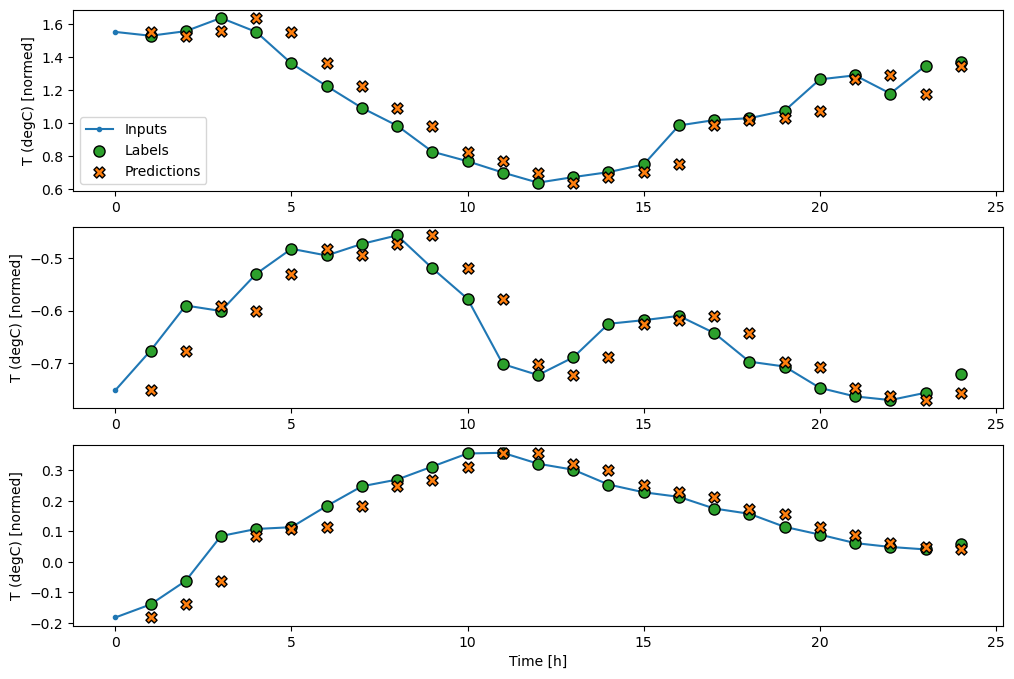

In [42]:
wide_window.plot(baseline)

### Linear Model

This is the simplest model you can train. "A `tf.keras.layers.Dense` layer with no activation set is a linear model. 

The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the batch and time axes."

In [43]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [45]:
# Create function to train many models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [46]:
# Train the linear model and evaluate its performance
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0706 - mean_absolute_error: 0.1547 - val_loss: 0.0104 - val_mean_absolute_error: 0.0765
Epoch 2/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0100 - mean_absolute_error: 0.0740 - val_loss: 0.0090 - val_mean_absolute_error: 0.0703
Epoch 3/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0710 - val_loss: 0.0087 - val_mean_absolute_error: 0.0689
Epoch 4/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705 - val_loss: 0.0088 - val_mean_absolute_error: 0.0691
Epoch 5/20
439/439 [==============================] - 0s 973us/step - loss: 0.0088 - mean_absolute_error: 0.0689


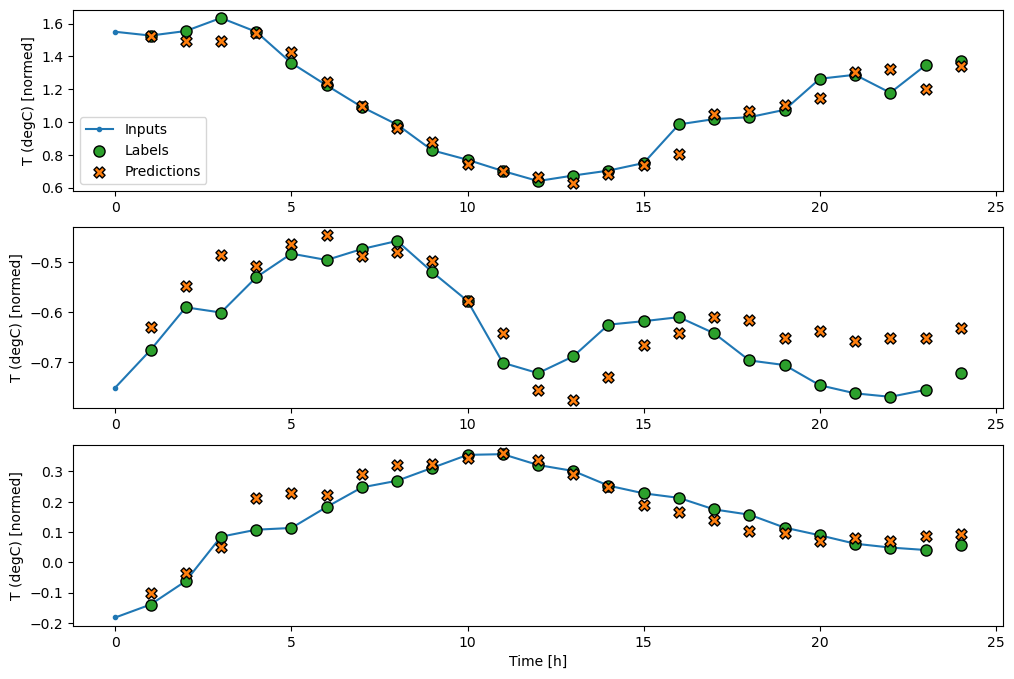

In [47]:
# Plot the linear model and the predictions
wide_window.plot(linear)

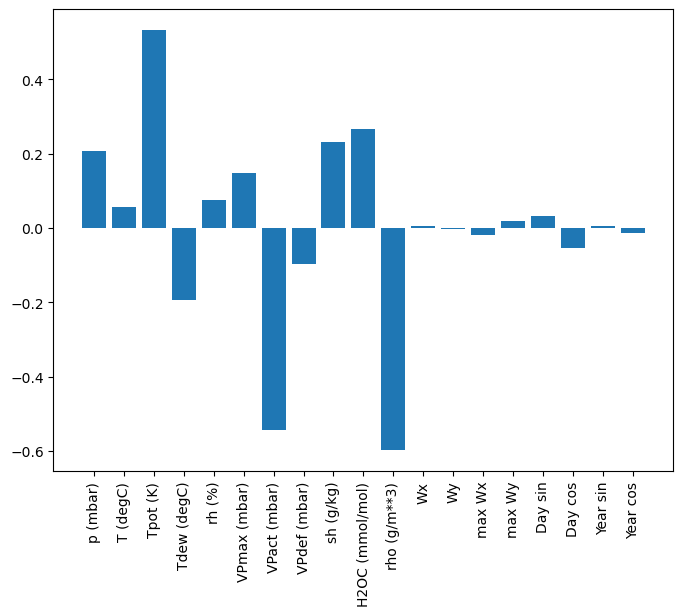

In [48]:
# Linear models are easy to interpret. You can pull out the weights and plot them
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [49]:
# Evaluate the performance of a deep, single-step model
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0177 - mean_absolute_error: 0.0815 - val_loss: 0.0077 - val_mean_absolute_error: 0.0624
Epoch 2/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0640 - val_loss: 0.0090 - val_mean_absolute_error: 0.0668
Epoch 3/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0074 - mean_absolute_error: 0.0618 - val_loss: 0.0070 - val_mean_absolute_error: 0.0601
Epoch 4/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0602 - val_loss: 0.0068 - val_mean_absolute_error: 0.0588
Epoch 5/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0592 - val_loss: 0.0067 - val_mean_absolute_error: 0.0588
Epoch 6/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0587 - val_loss: 0.0069 - val_mean_absolute_error: 0.0599
Epoc

### Recurrent Neural Network

In [50]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [124]:
print(np.arange(1,11,1).reshape(-1,1))
print(np.random.randint(0, 1, 10).reshape(1,-1))

[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
[[0 0 0 0 0 0 0 0 0 0]]


In [130]:
a = np.arange(1,11,1).reshape(-1,1)
b = np.random.randint(0, 1, 10).reshape(-1,1)
c = np.concatenate((a,b), axis = 1)
d = np.concatenate((c, a), axis = 1)
d

array([[ 1,  0,  1],
       [ 2,  0,  2],
       [ 3,  0,  3],
       [ 4,  0,  4],
       [ 5,  0,  5],
       [ 6,  0,  6],
       [ 7,  0,  7],
       [ 8,  0,  8],
       [ 9,  0,  9],
       [10,  0, 10]])

In [119]:
np.where(a>5, 0, 1)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [121]:
A = np.array([[1,2,3],[4,5,6], [7,8,9]])
A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [123]:
A[:, 1]

array([2, 5, 8])

In [133]:
np.min(A, axis = 0)

array([1, 2, 3])